In [140]:
import pandas as pd
import numpy as np 

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('data.json')
df

,repo,language,readme_contents
0,minvws/nl-covid19-notification-app-website,HTML,Content & Translations\n---------------------\...
1,heremaps/here-covid-19-tracker,JavaScript,"# HERE-COVID-2019\n\n*Update: March 17, 2020 -..."
2,trekhleb/covid-19,JavaScript,# Coronavirus (COVID-19) Dashboard\n\n📈 [**Cor...
3,PubInv/covid19-vent-list,None,# COVID-19 Ventilator Projects and Resources w...
4,JieYingWu/COVID-19_US_County-level_Summaries,HTML,# County-level Socioeconomic Data for Predicti...
...,...,...,...
198,simonblowsnow/COVID-19-Visualization,Python,\n# 2019新型冠状病毒疫情数据可视化、疫情历史数据分析、数据更新、数据清洗行政区域代码...
199,thepanacealab/covid19_twitter,Jupyter Notebook,## Latest Updates:\n\n2/12/23 Version 153 of t...
200,Coders-Of-XDA-OT/covid19-status-android,Java,# COVID-19 Status Android app\r\n\r\nAn androi...
201,lispc/covid19-citymap-china,JavaScript,# 中国新型冠状病毒肺炎疫情地级市图\n\n在网页上通过新浪新闻的 API 获得 __现存_...


In [3]:
df[df['readme_contents'] == '']

,repo,language,readme_contents
5,elcronos/COVID-19,JavaScript,
7,WorldHealthOrganization/app,Dart,
60,joanby/covid19,HTML,
76,k-sys/covid-19,Jupyter Notebook,


In [4]:
df = df[df['readme_contents'] != '']

In [5]:
def basic_clean(string):
    '''
    This function takes in the original text.
    The text is all lowercased, 
    the text is encoded in ascii and any characters that are not ascii are ignored.
    The text is then decoded in utf-8 and any characters that are not ascii are ignored
    Additionally, special characters are all removed.
    A clean article is then returned
    '''
    #lowercase
    string = string.lower()
    
    #normalize
    string = unicodedata.normalize('NFKD', string)\
    .encode('ascii', 'ignore')\
    .decode('utf-8', 'ignore')
    
    #remove special characters and replaces it with blank
    string = re.sub(r"[^a-z0-9'\s]", '', string)
    
    return string

In [6]:
def tokenize(string):
    '''
    This function takes in a string
    and returns the string as individual tokens put back into the string
    '''
    #create the tokenizer
    tokenizer = nltk.tokenize.ToktokTokenizer()

    #use the tokenizer
    string = tokenizer.tokenize(string, return_str = True)

    return string

In [7]:
def stem(string):
    '''
    This function takes in text
    and returns the stem word joined back into the text
    '''
    #create porter stemmer
    ps = nltk.porter.PorterStemmer()
    
    #use the stem, split string using each word
    stems = [ps.stem(word) for word in string.split()]
    
    #join stem word to string
    string = ' '.join(stems)

    return string

In [8]:
def lemmatize(string):
    '''
    This function takes in a string
    and returns the lemmatized word joined back into the string
    '''
    #create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    #look at the article 
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    #join lemmatized words into article
    string = ' '.join(lemmas)

    return string

In [9]:
def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in text, extra words and exclude words
    and returns a list of text with stopword removed
    '''
    #create stopword list
    stopword_list = stopwords.words('english')
    
    #remove excluded words from list
    stopword_list = set(stopword_list) - set(exclude_words)
    
    #add the extra words to the list
    stopword_list = stopword_list.union(set(extra_words))
    
    #split the string into different words
    words = string.split()
    
    #create a list of words that are not in the list
    filtered_words = [word for word in words if word not in stopword_list]
    
    #join the words that are not stopwords (filtered words) back into the string
    string = ' '.join(filtered_words)
    
    return string

In [10]:
def prep_data(df, column, extra_words=[], exclude_words=[]):
    '''
    This function take in a df and the string name for a text column with 
    option to pass lists for extra_words and exclude_words and
    returns a df with the text article title, original text, stemmed text,
    lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
    '''
    
    #chain together clean, tokenize, remove stopwords
    df['clean'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(remove_stopwords, 
                                   extra_words=extra_words, 
                                   exclude_words=exclude_words)
    
    #chain clean, tokenize, stem, remove stopwords
    df['stemmed'] = df['clean'].apply(stem)
    
    #clean clean, tokenize, lemmatize, remove stopwords
    df['lemmatized'] = df['clean'].apply(lemmatize)
    
    return df[['repo', 'language', 'clean', 'stemmed', 'lemmatized']]

In [11]:
df = prep_data(df, 'readme_contents')
df

,repo,language,clean,stemmed,lemmatized
0,minvws/nl-covid19-notification-app-website,HTML,content translations add question add feature ...,content translat add question add featur creat...,content translation add question add feature c...
1,heremaps/here-covid-19-tracker,JavaScript,herecovid2019 update march 17 2020 production ...,herecovid2019 updat march 17 2020 product vers...,herecovid2019 update march 17 2020 production ...
2,trekhleb/covid-19,JavaScript,coronavirus covid19 dashboard coronavirus covi...,coronaviru covid19 dashboard coronaviru covid1...,coronavirus covid19 dashboard coronavirus covi...
3,PubInv/covid19-vent-list,None,covid19 ventilator projects resources faqs lon...,covid19 ventil project resourc faq longer acti...,covid19 ventilator project resource faq longer...
4,JieYingWu/COVID-19_US_County-level_Summaries,HTML,countylevel socioeconomic data predictive mode...,countylevel socioeconom data predict model epi...,countylevel socioeconomic data predictive mode...
...,...,...,...,...,...
198,simonblowsnow/COVID-19-Visualization,Python,2019 covid192019ncov wuhancoronavirus visualiz...,2019 covid192019ncov wuhancoronaviru visual an...,2019 covid192019ncov wuhancoronavirus visualiz...
199,thepanacealab/covid19_twitter,Jupyter Notebook,latest updates 21223 version 153 dataset daily...,latest updat 21223 version 153 dataset daili d...,latest update 21223 version 153 dataset daily ...
200,Coders-Of-XDA-OT/covid19-status-android,Java,covid19 status android app android app track c...,covid19 statu android app android app track co...,covid19 status android app android app track c...
201,lispc/covid19-citymap-china,JavaScript,api github pages httpslispcgithubiocovid19city...,api github page httpslispcgithubiocovid19citym...,api github page httpslispcgithubiocovid19citym...


In [12]:
df['language'].value_counts()

Python              38
JavaScript          36
Jupyter Notebook    29
HTML                19
R                    9
TypeScript           7
Kotlin               7
Vue                  5
Ruby                 3
TeX                  2
Dart                 2
PHP                  2
Go                   2
Objective-C          1
PowerShell           1
TSQL                 1
SCSS                 1
C#                   1
CSS                  1
Svelte               1
Stan                 1
Java                 1
Name: language, dtype: int64

In [13]:
def seperate_language(df):
    
    desired_languages = ['Python', 'JavaScript', 'Jupyter Notebook', 'HTML', 'R']

    mask = df['language'].isin(desired_languages)

    df['language'] = pd.np.where(mask, df['language'], 'others')

    return df

In [14]:
desired_languages = ['Python', 'JavaScript', 'Jupyter Notebook', 'HTML', 'R']

mask = df['language'].isin(desired_languages)

df['language'] = pd.np.where(mask, df['language'], 'others')

df

,repo,language,clean,stemmed,lemmatized
0,minvws/nl-covid19-notification-app-website,HTML,content translations add question add feature ...,content translat add question add featur creat...,content translation add question add feature c...
1,heremaps/here-covid-19-tracker,JavaScript,herecovid2019 update march 17 2020 production ...,herecovid2019 updat march 17 2020 product vers...,herecovid2019 update march 17 2020 production ...
2,trekhleb/covid-19,JavaScript,coronavirus covid19 dashboard coronavirus covi...,coronaviru covid19 dashboard coronaviru covid1...,coronavirus covid19 dashboard coronavirus covi...
3,PubInv/covid19-vent-list,others,covid19 ventilator projects resources faqs lon...,covid19 ventil project resourc faq longer acti...,covid19 ventilator project resource faq longer...
4,JieYingWu/COVID-19_US_County-level_Summaries,HTML,countylevel socioeconomic data predictive mode...,countylevel socioeconom data predict model epi...,countylevel socioeconomic data predictive mode...
...,...,...,...,...,...
198,simonblowsnow/COVID-19-Visualization,Python,2019 covid192019ncov wuhancoronavirus visualiz...,2019 covid192019ncov wuhancoronaviru visual an...,2019 covid192019ncov wuhancoronavirus visualiz...
199,thepanacealab/covid19_twitter,Jupyter Notebook,latest updates 21223 version 153 dataset daily...,latest updat 21223 version 153 dataset daili d...,latest update 21223 version 153 dataset daily ...
200,Coders-Of-XDA-OT/covid19-status-android,others,covid19 status android app android app track c...,covid19 statu android app android app track co...,covid19 status android app android app track c...
201,lispc/covid19-citymap-china,JavaScript,api github pages httpslispcgithubiocovid19city...,api github page httpslispcgithubiocovid19citym...,api github page httpslispcgithubiocovid19citym...


In [15]:
df['language'].value_counts()

others              68
Python              38
JavaScript          36
Jupyter Notebook    29
HTML                19
R                    9
Name: language, dtype: int64

In [16]:
len(df['language'])

199

In [17]:
def train_val_test(df,col):
    seed = 42
    
    ''' This function is to split our data into our train, validate, and test subsets. We put in a dataframe
    and our target variable to then return the subsets of train, validate and test.'''
    
    train, test = train_test_split(df, train_size = 0.7, random_state = seed, stratify = df[col])
    
    validate, test = train_test_split(test, test_size = 0.5, random_state = seed, stratify = test[col])
    
    return train, validate, test

In [18]:
train, validate, test = train_val_test(df, 'language')

train.shape, validate.shape, test.shape

((139, 5), (30, 5), (30, 5))

In [19]:
train

,repo,language,clean,stemmed,lemmatized
163,dssg-pt/covid19pt-data,Jupyter Notebook,dados relativos pandemia covid19 em portugal u...,dado relativo pandemia covid19 em portug ultim...,dado relativos pandemia covid19 em portugal ul...
192,kaz-ogiwara/covid19,HTML,coronavirus disease covid19 situation report j...,coronaviru diseas covid19 situat report japan ...,coronavirus disease covid19 situation report j...
63,disease-sh/API,JavaScript,logopublicassetsimgiconlongpng brbr dockerhub ...,logopublicassetsimgiconlongpng brbr dockerhub ...,logopublicassetsimgiconlongpng brbr dockerhub ...
17,pennsignals/chime,Python,chime looking chime repo moved please update f...,chime look chime repo move pleas updat fork ht...,chime looking chime repo moved please update f...
45,arpanmangal/CovidAID,Python,covidaid detection covid19 xray images present...,covidaid detect covid19 xray imag present covi...,covidaid detection covid19 xray image present ...
...,...,...,...,...,...
88,PatilShreyas/Covid19-Notifier-IN,others,p aligncenter img srcappsrcmainiclauncherplays...,p aligncent img srcappsrcmainiclauncherplaysto...,p aligncenter img srcappsrcmainiclauncherplays...
140,minvws/nl-covid19-notification-app-design,others,covid19 notification app design het ontwikkele...,covid19 notif app design het ontwikkelen en on...,covid19 notification app design het ontwikkele...
27,MinCiencia/Datos-COVID19,Jupyter Notebook,datoscovid19 el objetivo de la mesa de datos c...,datoscovid19 el objetivo de la mesa de dato co...,datoscovid19 el objetivo de la mesa de datos c...
95,sfu-db/covid19-datasets,HTML,covid19 datasets apis list projects vision dev...,covid19 dataset api list project vision develo...,covid19 datasets apis list project vision deve...


In [20]:
train_java = train[train['language'] == 'JavaScript']
train_juypter =train[train['language'] == 'Jupyter Notebook']

(-0.5, 399.5, 199.5, -0.5)

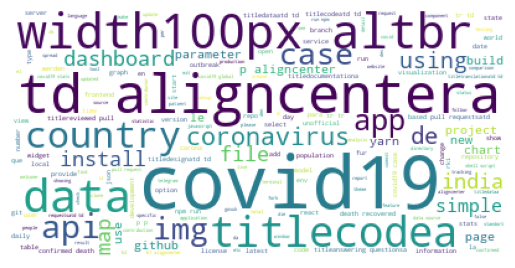

In [21]:
repo_java_lem = ' '.join(train_java['lemmatized'])

blog_img = WordCloud(background_color='white').generate(repo_java_lem)
plt.imshow(blog_img)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

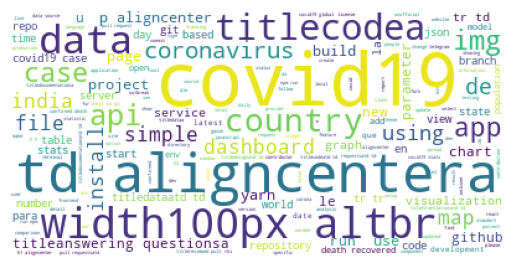

In [22]:
repo_jupyter_lem = ' '.join(train_java['lemmatized'])

blog_img = WordCloud(background_color='white').generate(repo_jupyter_lem)
plt.imshow(blog_img)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

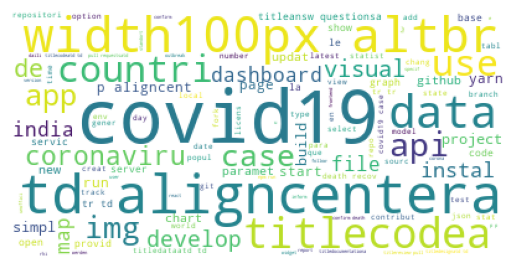

In [23]:
repo_jupyter_stem = ' '.join(train_java['stemmed'])

blog_img = WordCloud(background_color='white').generate(repo_jupyter_stem)
plt.imshow(blog_img)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

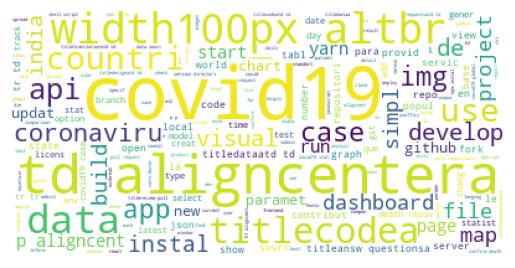

In [24]:
repo_java_stem = ' '.join(train_java['stemmed'])

blog_img = WordCloud(background_color='white').generate(repo_java_stem)
plt.imshow(blog_img)
plt.axis('off')

In [25]:
labels = pd.concat([train.language.value_counts(),
                    train.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels


,n,percent
others,48,0.345324
Python,27,0.194245
JavaScript,25,0.179856
Jupyter Notebook,20,0.143885
HTML,13,0.093525
R,6,0.043165


In [26]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(train, "language")


,n,percent
others,48,0.345324
Python,27,0.194245
JavaScript,25,0.179856
Jupyter Notebook,20,0.143885
HTML,13,0.093525
R,6,0.043165


In [27]:
tokenize = nltk.tokenize.ToktokTokenizer()
#java_words = tokenize.tokenize(repo_java_lem)
#java_words

In [28]:
#java_freq_words = pd.Series(java_words).value_counts()
#java_freq_words

In [29]:
jupyter_words = tokenize.tokenize(repo_jupyter_lem)
jupyter_freq_words = pd.Series(jupyter_words).value_counts()
jupyter_freq_words

covid19                                                            184
td                                                                 120
width100px                                                         107
aligncentera                                                       104
altbr                                                              102
                                                                  ... 
hrefhttpsgithubcomneherlabcovid19scenarioscommitsauthoraschelch      1
hrefquestionaschelch                                                 1
hreftranslationaschelch                                              1
hrefhttpsgithubcombharath6365img                                     1
hellocovid19indiaorg                                                 1
Length: 3565, dtype: int64

## Modeling

In [30]:
train

,repo,language,clean,stemmed,lemmatized
163,dssg-pt/covid19pt-data,Jupyter Notebook,dados relativos pandemia covid19 em portugal u...,dado relativo pandemia covid19 em portug ultim...,dado relativos pandemia covid19 em portugal ul...
192,kaz-ogiwara/covid19,HTML,coronavirus disease covid19 situation report j...,coronaviru diseas covid19 situat report japan ...,coronavirus disease covid19 situation report j...
63,disease-sh/API,JavaScript,logopublicassetsimgiconlongpng brbr dockerhub ...,logopublicassetsimgiconlongpng brbr dockerhub ...,logopublicassetsimgiconlongpng brbr dockerhub ...
17,pennsignals/chime,Python,chime looking chime repo moved please update f...,chime look chime repo move pleas updat fork ht...,chime looking chime repo moved please update f...
45,arpanmangal/CovidAID,Python,covidaid detection covid19 xray images present...,covidaid detect covid19 xray imag present covi...,covidaid detection covid19 xray image present ...
...,...,...,...,...,...
88,PatilShreyas/Covid19-Notifier-IN,others,p aligncenter img srcappsrcmainiclauncherplays...,p aligncent img srcappsrcmainiclauncherplaysto...,p aligncenter img srcappsrcmainiclauncherplays...
140,minvws/nl-covid19-notification-app-design,others,covid19 notification app design het ontwikkele...,covid19 notif app design het ontwikkelen en on...,covid19 notification app design het ontwikkele...
27,MinCiencia/Datos-COVID19,Jupyter Notebook,datoscovid19 el objetivo de la mesa de datos c...,datoscovid19 el objetivo de la mesa de dato co...,datoscovid19 el objetivo de la mesa de datos c...
95,sfu-db/covid19-datasets,HTML,covid19 datasets apis list projects vision dev...,covid19 dataset api list project vision develo...,covid19 datasets apis list project vision deve...


In [110]:
train['stemmed'][0]

'content translat add question add featur creat markdown file question follow templat md set 3 index 6 titl question x lang nl answer markdown goe contain codehtmlcod set field valu 1top5 2opensourc 3app 4develop use pleas also includ name part prefix file eg appxmd content format take look exampl content pagehttpsminvwsgithubionlcovid19notificationappwebsiteenexamplecontentpag sourc markdownexamplecontentpagemd display possibl content format option display option also avail highlightedfaq question translat pleas give file short english name without space use dash instead least provid base file lang nl translat name lang suffix lang languag keyword eg en see file readmei18nmdreadmei18nmd technic detail'

In [79]:
# Create a CountVectorizer
count_vectorizer = CountVectorizer(stop_words="english")

# Fit and transform the "clean" column using the CountVectorizer
clean_count = count_vectorizer.fit_transform(train["clean"])

# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

# Fit and transform the "clean" column using the TfidfVectorizer
clean_tfidf = tfidf_vectorizer.fit_transform(train["clean"])

In [80]:
# Create a DecisionTreeClassifier using the CountVectorizer
dtc_count = DecisionTreeClassifier()
dtc_count.fit(clean_count, train["language"])

DecisionTreeClassifier()

In [81]:
# Predict using the CountVectorizer model
count_pred = dtc_count.predict(clean_count)
print("Accuracy with CountVectorizer:", accuracy_score(train["language"], count_pred))

Accuracy with CountVectorizer: 1.0


In [82]:
# Create a DecisionTreeClassifier using the TfidfVectorizer
dtc_tfidf = DecisionTreeClassifier()
dtc_tfidf.fit(clean_tfidf, train["language"])

DecisionTreeClassifier()

In [83]:
# Predict using the TfidfVectorizer model
tfidf_pred = dtc_tfidf.predict(clean_tfidf)
print("Accuracy with TfidfVectorizer:", accuracy_score(train["language"], tfidf_pred))

Accuracy with TfidfVectorizer: 1.0


In [85]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the training data and transform the data
X_train_vec = vectorizer.fit_transform(train['lemmatized'])

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(test['lemmatized'])

# Define the model
clf = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
clf.fit(X_train_vec, train['language'])

# Predict the language labels for the test data
y_pred = clf.predict(X_test_vec)

# Calculate evaluation metrics
accuracy = accuracy_score(test['language'], y_pred)
precision = precision_score(test['language'], y_pred, average='weighted')
recall = recall_score(test['language'], y_pred, average='weighted')
f1 = f1_score(test['language'], y_pred, average='weighted')
cm = confusion_matrix(test['language'], y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:\n', cm)


Accuracy: 0.3333333333333333
Precision: 0.4137566137566137
Recall: 0.3333333333333333
F1 Score: 0.36176338281601433
Confusion Matrix:
 [[0 1 0 0 0 2]
 [1 2 2 1 0 0]
 [0 0 2 1 1 0]
 [2 0 0 1 1 2]
 [0 0 0 1 0 0]
 [0 0 0 3 2 5]]


In [91]:
len(y_test_pred)

33

In [92]:
len(test)

33

In [153]:

# Split the data into train, validation, and test sets
train = df[:136]
valid = df[136:166]
test = df[166:]

# Fit a TF-IDF vectorizer on the train data and transform the data
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(train['lemmatized'])

# Transform the validation data and test data using the same vectorizer
X_valid_vec = vectorizer.transform(valid['lemmatized'])
X_test_vec = vectorizer.transform(test['lemmatized'])

# Fit a decision tree classifier on the train data and predict the validation data
dtc = DecisionTreeClassifier()
dtc.fit(X_train_vec, train['language'])
y_valid_pred = dtc.predict(X_valid_vec)

# Evaluate the model on the validation data
print("Validation set evaluation:")
print("Accuracy:", accuracy_score(valid['language'], y_valid_pred))
print("Precision:", precision_score(valid['language'], y_valid_pred, average='macro'))
print("Recall:", recall_score(valid['language'], y_valid_pred, average='macro'))
print("F1 Score:", f1_score(valid['language'], y_valid_pred, average='macro'))
print("Confusion matrix:\n", confusion_matrix(valid['language'], y_valid_pred))

# Fit a decision tree classifier on the train data and predict the test data
dtc.fit(X_train_vec, train['language'])
y_test_pred = dtc.predict(X_test_vec)

# Evaluate the model on the test data
print("\nTest set evaluation:")
print("Accuracy:", accuracy_score(test['language'], y_test_pred))
print("Precision:", precision_score(test['language'], y_test_pred, average='macro'))
print("Recall:", recall_score(test['language'], y_test_pred, average='macro'))
print("F1 Score:", f1_score(test['language'], y_test_pred, average='macro'))
print("Confusion matrix:\n", confusion_matrix(test['language'], y_test_pred))

# Generate predicted labels for the test data
y_test_pred = dtc.predict(X_test_vec)
#y_test_pred = y_test_pred.tolist()

# Print the actual and predicted language for each row in the test data
for i, row in test.iterrows():
    print("Actual language: {}, Predicted language: {}".format(row['language'], y_test_pred[i]))


Validation set evaluation:
Accuracy: 0.23333333333333334
Precision: 0.2333333333333333
Recall: 0.15277777777777776
F1 Score: 0.15
Confusion matrix:
 [[0 0 1 0 0 1]
 [1 1 1 0 0 1]
 [0 0 0 2 0 2]
 [2 0 3 0 0 3]
 [0 0 1 0 0 2]
 [2 0 0 1 0 6]]

Test set evaluation:
Accuracy: 0.36363636363636365
Precision: 0.2512820512820513
Recall: 0.2714285714285714
F1 Score: 0.2571428571428572
Confusion matrix:
 [[0 1 0 1 0 1]
 [0 4 0 0 0 4]
 [1 0 1 1 0 2]
 [0 1 2 3 0 1]
 [0 0 1 0 0 1]
 [0 1 1 2 0 4]]


IndexError: index 170 is out of bounds for axis 0 with size 33

In [150]:
test = pd.Series(test['language'])

170              Python
171              Python
172                   R
173              Python
174    Jupyter Notebook
175              others
176    Jupyter Notebook
177              others
178              Python
179    Jupyter Notebook
180    Jupyter Notebook
181              others
182              others
183              others
184          JavaScript
185              Python
186                HTML
187              others
188          JavaScript
189              others
190          JavaScript
191          JavaScript
192                HTML
193                   R
194              Python
195          JavaScript
196          JavaScript
197                HTML
198              Python
199    Jupyter Notebook
200              others
201          JavaScript
202          JavaScript
Name: language, dtype: object

In [119]:
y_test_pred

['Python',
 'Python',
 'others',
 'Jupyter Notebook',
 'Python',
 'HTML',
 'others',
 'others',
 'Python',
 'R',
 'Jupyter Notebook',
 'Jupyter Notebook',
 'Python',
 'HTML',
 'JavaScript',
 'others',
 'others',
 'Jupyter Notebook',
 'others',
 'Python',
 'JavaScript',
 'others',
 'Python',
 'Jupyter Notebook',
 'Python',
 'JavaScript',
 'JavaScript',
 'JavaScript',
 'JavaScript',
 'others',
 'others',
 'others',
 'others']

In [148]:
test['language']

170              Python
171              Python
172                   R
173              Python
174    Jupyter Notebook
175              others
176    Jupyter Notebook
177              others
178              Python
179    Jupyter Notebook
180    Jupyter Notebook
181              others
182              others
183              others
184          JavaScript
185              Python
186                HTML
187              others
188          JavaScript
189              others
190          JavaScript
191          JavaScript
192                HTML
193                   R
194              Python
195          JavaScript
196          JavaScript
197                HTML
198              Python
199    Jupyter Notebook
200              others
201          JavaScript
202          JavaScript
Name: language, dtype: object

In [121]:
test['language'].tolist()

['Python',
 'Python',
 'R',
 'Python',
 'Jupyter Notebook',
 'others',
 'Jupyter Notebook',
 'others',
 'Python',
 'Jupyter Notebook',
 'Jupyter Notebook',
 'others',
 'others',
 'others',
 'JavaScript',
 'Python',
 'HTML',
 'others',
 'JavaScript',
 'others',
 'JavaScript',
 'JavaScript',
 'HTML',
 'R',
 'Python',
 'JavaScript',
 'JavaScript',
 'HTML',
 'Python',
 'Jupyter Notebook',
 'others',
 'JavaScript',
 'JavaScript']

In [115]:
y_test_pred.tolist()

['Python',
 'Python',
 'others',
 'Python',
 'Python',
 'HTML',
 'others',
 'others',
 'Python',
 'HTML',
 'Jupyter Notebook',
 'Jupyter Notebook',
 'Python',
 'Python',
 'JavaScript',
 'others',
 'others',
 'Jupyter Notebook',
 'others',
 'Python',
 'JavaScript',
 'others',
 'Python',
 'Python',
 'Python',
 'others',
 'JavaScript',
 'Python',
 'JavaScript',
 'others',
 'others',
 'others',
 'others']

In [122]:
for index, row in test.iterrows():
    print("Actual language: {}, Predicted language: {}".format(row['language'], y_test_pred[index]))

IndexError: list index out of range

In [123]:
for actual_lang, predicted_lang in zip(test['language'].tolist(), y_test_pred):
    print("Actual language: {}, Predicted language: {}".format(actual_lang, predicted_lang))


Actual language: Python, Predicted language: Python
Actual language: Python, Predicted language: Python
Actual language: R, Predicted language: others
Actual language: Python, Predicted language: Jupyter Notebook
Actual language: Jupyter Notebook, Predicted language: Python
Actual language: others, Predicted language: HTML
Actual language: Jupyter Notebook, Predicted language: others
Actual language: others, Predicted language: others
Actual language: Python, Predicted language: Python
Actual language: Jupyter Notebook, Predicted language: R
Actual language: Jupyter Notebook, Predicted language: Jupyter Notebook
Actual language: others, Predicted language: Jupyter Notebook
Actual language: others, Predicted language: Python
Actual language: others, Predicted language: HTML
Actual language: JavaScript, Predicted language: JavaScript
Actual language: Python, Predicted language: others
Actual language: HTML, Predicted language: others
Actual language: others, Predicted language: Jupyter N

In [125]:
# Create a new data frame for the actual and predicted language
results = pd.DataFrame(columns=['Actual Language', 'Predicted Language'])

# Fill the data frame with the actual and predicted values
for actual_lang, predicted_lang in zip(test['language'].tolist(), y_test_pred):
    print("Actual language: {}, Predicted language: {}".format(actual_lang, predicted_lang))


# Print the results data frame
print(results)


Actual language: Python, Predicted language: Python
Actual language: Python, Predicted language: Python
Actual language: R, Predicted language: others
Actual language: Python, Predicted language: Jupyter Notebook
Actual language: Jupyter Notebook, Predicted language: Python
Actual language: others, Predicted language: HTML
Actual language: Jupyter Notebook, Predicted language: others
Actual language: others, Predicted language: others
Actual language: Python, Predicted language: Python
Actual language: Jupyter Notebook, Predicted language: R
Actual language: Jupyter Notebook, Predicted language: Jupyter Notebook
Actual language: others, Predicted language: Jupyter Notebook
Actual language: others, Predicted language: Python
Actual language: others, Predicted language: HTML
Actual language: JavaScript, Predicted language: JavaScript
Actual language: Python, Predicted language: others
Actual language: HTML, Predicted language: others
Actual language: others, Predicted language: Jupyter N

In [127]:
# Create a new data frame for the actual and predicted language
results = pd.DataFrame(columns=['Actual Language', 'Predicted Language'])

# Fill the data frame with the actual and predicted values
for i, row in test.iterrows():
    actual_lang = row['language']
    predicted_lang = y_test_pred[i]
    results.loc[i] = [actual_lang, predicted_lang]

# Print the results data frame
results


IndexError: list index out of range

In [128]:
cv = CountVectorizer()
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=2, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 37.04%


In [129]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=17, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 29.63%


In [130]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=26, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 29.63%


In [131]:
cv = CountVectorizer(ngram_range=(3, 3))
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=25, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 33.33%


In [132]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

In [133]:
baseline=(y_train=='others').mean()
print('The baseline accuracy is ',baseline)

The baseline accuracy is  0.38271604938271603


In [134]:
cv = CountVectorizer()
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

bwtree = DecisionTreeClassifier(max_depth=12, random_state=123)
bwtree.fit(X_train, y_train)

print(f'Accuracy Score: {bwtree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 33.33%


In [135]:
# TF-IDF approach
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

tftree = DecisionTreeClassifier(max_depth=17, random_state=13)
tftree.fit(X_train, y_train)

print(f'Accuracy Score: {tftree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 40.74%


In [136]:
# Bigram approach
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

bitree = DecisionTreeClassifier(max_depth=16, random_state=13)
bitree.fit(X_train, y_train)

print(f'Accuracy Score: {bitree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 40.74%


In [137]:
# Tri-gram
cv = CountVectorizer(ngram_range=(3, 3))
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

titree = DecisionTreeClassifier(max_depth=12, random_state=123)
titree.fit(X_train, y_train)

print(f'Accuracy Score: {titree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 33.33%


In [141]:
cv = CountVectorizer()
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

bwtree = DecisionTreeClassifier(max_depth=12, random_state=123)
bwtree.fit(X_train, y_train)

preds = bwtree.predict(X_test)
print(classification_report(y_test, preds))

                  precision    recall  f1-score   support

            HTML       0.00      0.00      0.00         1
      JavaScript       0.13      0.50      0.21         4
Jupyter Notebook       0.00      0.00      0.00         6
          Python       0.50      0.50      0.50         4
               R       0.00      0.00      0.00         2
          others       0.20      0.09      0.13        11

        accuracy                           0.18        28
       macro avg       0.14      0.18      0.14        28
    weighted avg       0.17      0.18      0.15        28

